In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
from rom_tools import rom_manager
from rom_tools import graphics
import numpy as np

In [3]:
rom_m = rom_manager.RomManager("../roms/sm_guinea_pig.smc", "../roms/sm_newlevel.smc")

In [4]:
tileset_table = graphics.get_tileset_table(rom_m)

In [5]:
uc_tile_table, uc_tile_sheet, uc_palette = graphics.get_tileset(rom_m, 0, tileset_table)

In [6]:
cre_tile_sheet = graphics.get_cre_tilesheet(rom_m)
cre_tile_table = graphics.get_cre_tile_table(rom_m)

In [7]:
len(uc_tile_table)

768

In [8]:
graphics.save_tile_table_image("test.png", uc_tile_table, 32, 24, uc_tile_sheet, cre_tile_sheet, uc_palette)

## Level Data

In [10]:
from texture_gen import wave_collapse
from world_rando import room_gen
from world_rando import room_viz
from world_rando.coord import *
from rom_tools.address import *
from rom_tools.compress import decompress
from world_rando import room_dtypes
from world_rando import room_utils

In [74]:
# Now we will display room 0x792b3 with our newfound abilities
#room_header_addr = Address(0x792b3)
#room_header_addr = Address(0x79e9f)
room_header_addr = Address(0x79f11)
#room_header_addr = Address(0x7a107)
room_header = rom_m.read_from_clean(room_header_addr, 74)

In [75]:
# Find the level data
print(room_header)
leveldata_ptr_b = room_header[18:21]
#leveldata_ptr_b = room_header[13:16] # 7a107
print(leveldata_ptr_b)
leveldata_ptr_snes = int.from_bytes(leveldata_ptr_b, byteorder='little')
print(hex(leveldata_ptr_snes))
leveldata_addr = Address(leveldata_ptr_snes, mode="snes")

b'\x0f\x01\x1d\n\x01\x02p\xa0\x00W\x9f\x12\xe6\x00=\x9f\xe6\xe5:\xe6\xc5\x06\x00\x00\xa0\x82\xc6\x9b\x95\x85\xc1\xc1]\x9f\x00\x00\x00\x00T\x87\xbe\xba\xd5\x91:\xe6\xc5\x06\x00\x00\xf4\x81\x8d\x91w\x83\xc1\xc1]\x9f\x00\x00\x00\x00T\x87\xbe\xba\xbc\x91\xc2\x8e\xce\x8e'
b':\xe6\xc5'
0xc5e63a


In [76]:
compressed_level_data = rom_m.read_from_clean(leveldata_addr, 5000)
level_data = decompress.decompress(compressed_level_data)
len(level_data)

1538

In [77]:
#size = Coord(5 * 16, 1 * 16) # 792b3
#size = Coord(8 * 16, 3 * 16) # 79e9f
size = Coord(1 * 16, 2 * 16) # 79f11
#size = Coord(1 * 16, 1 * 16) # 7a107
level = room_gen.level_from_bytes(level_data, size)

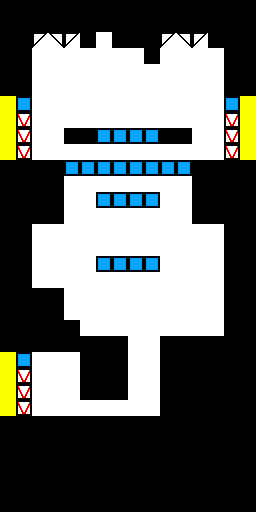

In [78]:
room_viz.room_viz(level, "test.png", "encoding/room_tiles")

In [79]:
#uc_tile_table, uc_tile_sheet, uc_palette = graphics.get_tileset(rom_m, 0, tileset_table) # 792b3
uc_tile_table, uc_tile_sheet, uc_palette = graphics.get_tileset(rom_m, 6, tileset_table) # 79e9f
cre_tile_sheet = graphics.get_cre_tilesheet(rom_m)
cre_tile_table = graphics.get_cre_tile_table(rom_m)

In [80]:
sce_tiles = graphics.tile_images(uc_tile_table, uc_tile_sheet, cre_tile_sheet, uc_palette)
cre_tiles = graphics.tile_images(cre_tile_table, uc_tile_sheet, cre_tile_sheet, uc_palette)

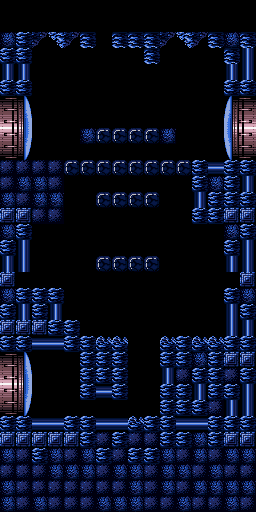

In [81]:
graphics.level_image(level, sce_tiles, cre_tiles)

In [82]:
lba = room_gen.bit_array_from_bytes(level_data, size)

In [83]:
lba.shape
np.save("data.npy", lba)

In [106]:
import numpy as np

In [160]:
def level_to_array(level):
    a = np.empty((level.dimensions.x, level.dimensions.y, 2), dtype="object")
    for c in level.itercoords():
        a[c.x, c.y, 0] = level[c].texture
        a[c.x, c.y, 1] = level[c].tile_type
    return a

def level_to_tex_array(level):
    a = np.empty((level.dimensions.x, level.dimensions.y, 1), dtype="object")
    for c in level.itercoords():
        a[c.x, c.y, 0] = level[c].texture
    return a

def level_from_array(array):
    dim = Coord(array.shape[0], array.shape[1])
    l = Level(dim)
    for index in np.ndindex(array.shape[0], array.shape[1]):
        i0 = index[0]
        i1 = index[1]
        c = Coord(i0, i1)
        texture = array[i0, i1, 0]
        tile_type = array[i0, i1, 1]
        t = Tile(texture, tile_type)
        l[c] = t
    return l

def level_from_tex_array(array):
    dim = Coord(array.shape[0], array.shape[1])
    l = room_dtypes.Level(dim)
    t = room_dtypes.Type(0, 0)
    for index in np.ndindex(array.shape[0], array.shape[1]):
        c = Coord(index[0], index[1])
        if array[index][0] is not None:
            l[c] = room_dtypes.Tile(array[index][0], t)
    return l

In [164]:
level_np = level_to_tex_array(level)
out_level = np.empty(level_np.shape, dtype="object")
level_np.shape

(80, 16, 1)

In [165]:
wave_collapse.tilewise_wavecollapse(level_np, out_level, (5,5,1))

Tile Size: (5, 5, 1)
Found 744 unique tiles
Initializing Subs
Iteration: 0
912 options for collapse with 9.11970311774939 choices
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,

Pos: (46, 0, 0)
Affecting (42, 0, 0) through [47, 5, 1]
For a total of (5, 5, 1)
Initially 744 tiles matched
Removed 657 tiles at (42, 0, 0)
Initially 744 tiles matched
Removed 607 tiles at (42, 1, 0)
Initially 744 tiles matched
Removed 552 tiles at (42, 2, 0)
Initially 744 tiles matched
Removed 497 tiles at (42, 3, 0)
Initially 744 tiles matched
Removed 459 tiles at (42, 4, 0)
Initially 744 tiles matched
Removed 692 tiles at (43, 0, 0)
Initially 744 tiles matched
Removed 649 tiles at (43, 1, 0)
Initially 744 tiles matched
Removed 600 tiles at (43, 2, 0)
Initially 744 tiles matched
Removed 551 tiles at (43, 3, 0)
Initially 744 tiles matched
Removed 514 tiles at (43, 4, 0)
Initially 744 tiles matched
Removed 718 tiles at (44, 0, 0)
Initially 744 tiles matched
Removed 683 tiles at (44, 1, 0)
Initially 744 tiles matched
Removed 641 tiles at (44, 2, 0)
Initially 744 tiles matched
Removed 599 tiles at (44, 3, 0)
Initially 744 tiles matched
Removed 564 tiles at (44, 4, 0)
Initially 744 tiles

Initially 744 tiles matched
Removed 722 tiles at (35, 2, 0)
Initially 744 tiles matched
Removed 720 tiles at (35, 3, 0)
Initially 744 tiles matched
Removed 720 tiles at (35, 4, 0)
Initially 87 tiles matched
Removed 23 tiles at (36, 0, 0)
Initially 137 tiles matched
Removed 75 tiles at (36, 1, 0)
Initially 192 tiles matched
Removed 183 tiles at (36, 2, 0)
Initially 247 tiles matched
Removed 235 tiles at (36, 3, 0)
Initially 285 tiles matched
Removed 273 tiles at (36, 4, 0)
Initially 52 tiles matched
Removed 20 tiles at (37, 0, 0)
Initially 95 tiles matched
Removed 64 tiles at (37, 1, 0)
Initially 144 tiles matched
Removed 139 tiles at (37, 2, 0)
Initially 193 tiles matched
Removed 186 tiles at (37, 3, 0)
Initially 230 tiles matched
Removed 223 tiles at (37, 4, 0)
Initially 26 tiles matched
Removed 12 tiles at (38, 0, 0)
Initially 61 tiles matched
Removed 58 tiles at (38, 1, 0)
Initially 103 tiles matched
Removed 101 tiles at (38, 2, 0)
Initially 145 tiles matched
Removed 143 tiles at (3

Removed 0 tiles at (43, 2, 0)
Initially 1 tiles matched
Removed 0 tiles at (43, 3, 0)
Initially 1 tiles matched
Removed 0 tiles at (43, 4, 0)
Initially 1 tiles matched
Removed 0 tiles at (44, 0, 0)
Initially 1 tiles matched
Removed 0 tiles at (44, 1, 0)
Initially 8 tiles matched
Removed 7 tiles at (44, 2, 0)
Initially 11 tiles matched
Removed 10 tiles at (44, 3, 0)
Initially 16 tiles matched
Removed 15 tiles at (44, 4, 0)
Iteration: 15
1 options for collapse with 3.5213235796433255 choices
{515, 523, 534, 30, 163, 164, 678, 679, 41, 42, 297, 432, 689, 690, 305, 433, 53, 54, 312, 313, 440, 441, 701, 702, 64, 65, 66, 448, 449, 713, 714, 75, 76, 330, 338, 339, 86, 87, 615, 239, 625}
Collapsed (46, 2, 0)
Indices:
Pos: (46, 2, 0)
Affecting (42, 0, 0) through [47, 5, 1]
For a total of (5, 5, 1)
Initially 1 tiles matched
Removed 0 tiles at (42, 0, 0)
Initially 1 tiles matched
Removed 1 tiles at (42, 1, 0)
Initially 1 tiles matched
Removed 1 tiles at (42, 2, 0)
Initially 1 tiles matched
Remove

Initially 744 tiles matched
Removed 744 tiles at (46, 5, 0)
Initially 744 tiles matched
Removed 744 tiles at (46, 6, 0)
Initially 744 tiles matched
Removed 743 tiles at (46, 7, 0)
Initially 744 tiles matched
Removed 743 tiles at (46, 8, 0)
Initially 744 tiles matched
Removed 743 tiles at (46, 9, 0)
Initially 744 tiles matched
Removed 744 tiles at (47, 5, 0)
Initially 744 tiles matched
Removed 744 tiles at (47, 6, 0)
Initially 744 tiles matched
Removed 743 tiles at (47, 7, 0)
Initially 744 tiles matched
Removed 743 tiles at (47, 8, 0)
Initially 1 tiles matched
Removed 0 tiles at (47, 9, 0)
Iteration: 18
3 options for collapse with 1.0 choices
{688, 161}
Collapsed (45, 9, 0)
Indices:
Pos: (45, 9, 0)
Affecting (41, 5, 0) through [46, 10, 1]
For a total of (5, 5, 1)
Initially 744 tiles matched
Removed 744 tiles at (41, 5, 0)
Initially 744 tiles matched
Removed 744 tiles at (41, 6, 0)
Initially 744 tiles matched
Removed 730 tiles at (41, 7, 0)
Initially 744 tiles matched
Removed 730 tiles a

Initially 744 tiles matched
Removed 744 tiles at (32, 5, 0)
Initially 744 tiles matched
Removed 744 tiles at (32, 6, 0)
Initially 744 tiles matched
Removed 744 tiles at (32, 7, 0)
Initially 744 tiles matched
Removed 744 tiles at (32, 8, 0)
Initially 744 tiles matched
Removed 743 tiles at (32, 9, 0)
Initially 0 tiles matched
Removed 0 tiles at (33, 5, 0)
Initially 0 tiles matched
Removed 0 tiles at (33, 6, 0)
Initially 0 tiles matched
Removed 0 tiles at (33, 7, 0)
Initially 0 tiles matched
Removed 0 tiles at (33, 8, 0)
Initially 12 tiles matched
Removed 11 tiles at (33, 9, 0)
Initially 0 tiles matched
Removed 0 tiles at (34, 5, 0)
Initially 0 tiles matched
Removed 0 tiles at (34, 6, 0)
Initially 0 tiles matched
Removed 0 tiles at (34, 7, 0)
Initially 0 tiles matched
Removed 0 tiles at (34, 8, 0)
Initially 1 tiles matched
Removed 0 tiles at (34, 9, 0)
Iteration: 24
1 options for collapse with 3.459431618637298 choices
{161, 676, 645, 711, 303, 688, 84, 149, 438, 311, 504}
Collapsed (30, 

Initially 7 tiles matched
Removed 0 tiles at (18, 5, 0)
Initially 7 tiles matched
Removed 0 tiles at (18, 6, 0)
Initially 7 tiles matched
Removed 0 tiles at (18, 7, 0)
Initially 5 tiles matched
Removed 0 tiles at (18, 8, 0)
Initially 4 tiles matched
Removed 0 tiles at (19, 4, 0)
Initially 6 tiles matched
Removed 0 tiles at (19, 5, 0)
Initially 6 tiles matched
Removed 0 tiles at (19, 6, 0)
Initially 6 tiles matched
Removed 0 tiles at (19, 7, 0)
Initially 4 tiles matched
Removed 0 tiles at (19, 8, 0)
Initially 0 tiles matched
Removed 0 tiles at (20, 4, 0)
Initially 1 tiles matched
Removed 1 tiles at (20, 5, 0)
Initially 1 tiles matched
Removed 1 tiles at (20, 6, 0)
Initially 1 tiles matched
Removed 1 tiles at (20, 7, 0)
Initially 1 tiles matched
Removed 1 tiles at (20, 8, 0)
Initially 1 tiles matched
Removed 1 tiles at (21, 4, 0)
Initially 1 tiles matched
Removed 1 tiles at (21, 5, 0)
Initially 1 tiles matched
Removed 1 tiles at (21, 6, 0)
Initially 1 tiles matched
Removed 1 tiles at (21

Initially 744 tiles matched
Removed 744 tiles at (13, 3, 0)
Initially 744 tiles matched
Removed 742 tiles at (13, 4, 0)
Initially 744 tiles matched
Removed 742 tiles at (13, 5, 0)
Initially 744 tiles matched
Removed 602 tiles at (14, 1, 0)
Initially 744 tiles matched
Removed 744 tiles at (14, 2, 0)
Initially 744 tiles matched
Removed 744 tiles at (14, 3, 0)
Initially 744 tiles matched
Removed 743 tiles at (14, 4, 0)
Initially 744 tiles matched
Removed 743 tiles at (14, 5, 0)
Initially 744 tiles matched
Removed 602 tiles at (15, 1, 0)
Initially 744 tiles matched
Removed 744 tiles at (15, 2, 0)
Initially 744 tiles matched
Removed 744 tiles at (15, 3, 0)
Initially 1 tiles matched
Removed 0 tiles at (15, 4, 0)
Initially 2 tiles matched
Removed 1 tiles at (15, 5, 0)
Initially 744 tiles matched
Removed 602 tiles at (16, 1, 0)
Initially 744 tiles matched
Removed 744 tiles at (16, 2, 0)
Initially 744 tiles matched
Removed 744 tiles at (16, 3, 0)
Initially 1 tiles matched
Removed 0 tiles at (16

Initially 744 tiles matched
Removed 743 tiles at (9, 3, 0)
Initially 4 tiles matched
Removed 3 tiles at (9, 4, 0)
Initially 744 tiles matched
Removed 733 tiles at (10, 0, 0)
Initially 744 tiles matched
Removed 735 tiles at (10, 1, 0)
Initially 744 tiles matched
Removed 738 tiles at (10, 2, 0)
Initially 744 tiles matched
Removed 743 tiles at (10, 3, 0)
Initially 1 tiles matched
Removed 0 tiles at (10, 4, 0)
Iteration: 41
1 options for collapse with 1.0 choices
{164, 534}
Collapsed (6, 4, 0)
Indices:
Pos: (6, 4, 0)
Affecting (2, 0, 0) through [7, 5, 1]
For a total of (5, 5, 1)
Initially 744 tiles matched
Removed 436 tiles at (2, 0, 0)
Initially 744 tiles matched
Removed 484 tiles at (2, 1, 0)
Initially 744 tiles matched
Removed 544 tiles at (2, 2, 0)
Initially 744 tiles matched
Removed 604 tiles at (2, 3, 0)
Initially 744 tiles matched
Removed 657 tiles at (2, 4, 0)
Initially 744 tiles matched
Removed 489 tiles at (3, 0, 0)
Initially 744 tiles matched
Removed 538 tiles at (3, 1, 0)
Initi

1 options for collapse with 1.7709505944546688 choices
{288, 422, 150, 152, 666}
Collapsed (5, 3, 0)
Indices:
Pos: (5, 3, 0)
Affecting (1, 0, 0) through [6, 5, 1]
For a total of (5, 5, 1)
Initially 1 tiles matched
Removed 0 tiles at (1, 0, 0)
Initially 1 tiles matched
Removed 0 tiles at (1, 1, 0)
Initially 1 tiles matched
Removed 0 tiles at (1, 2, 0)
Initially 1 tiles matched
Removed 0 tiles at (1, 3, 0)
Initially 1 tiles matched
Removed 0 tiles at (1, 4, 0)
Initially 0 tiles matched
Removed 0 tiles at (2, 0, 0)
Initially 0 tiles matched
Removed 0 tiles at (2, 1, 0)
Initially 0 tiles matched
Removed 0 tiles at (2, 2, 0)
Initially 1 tiles matched
Removed 1 tiles at (2, 3, 0)
Initially 1 tiles matched
Removed 0 tiles at (2, 4, 0)
Initially 0 tiles matched
Removed 0 tiles at (3, 0, 0)
Initially 0 tiles matched
Removed 0 tiles at (3, 1, 0)
Initially 0 tiles matched
Removed 0 tiles at (3, 2, 0)
Initially 1 tiles matched
Removed 1 tiles at (3, 3, 0)
Initially 1 tiles matched
Removed 0 tiles 

Initially 0 tiles matched
Removed 0 tiles at (15, 2, 0)
Initially 0 tiles matched
Removed 0 tiles at (15, 3, 0)
Initially 0 tiles matched
Removed 0 tiles at (15, 4, 0)
Initially 2 tiles matched
Removed 1 tiles at (16, 0, 0)
Initially 1 tiles matched
Removed 0 tiles at (16, 1, 0)
Initially 0 tiles matched
Removed 0 tiles at (16, 2, 0)
Initially 0 tiles matched
Removed 0 tiles at (16, 3, 0)
Initially 0 tiles matched
Removed 0 tiles at (16, 4, 0)
Iteration: 54
2 options for collapse with 6.0688532966746855 choices
{260, 518, 135, 11, 268, 395, 525, 652, 146, 276, 662, 23, 407, 537, 284, 157, 416, 673, 546, 35, 292, 168, 426, 300, 556, 684, 47, 179, 307, 435, 566, 695, 314, 59, 443, 190, 576, 451, 707, 71, 201, 586, 332, 461, 719, 81, 212, 341, 596, 471, 91, 731, 350, 223, 606, 481, 102, 359, 616, 743, 234, 491, 113, 626, 243, 252, 371, 501, 124, 510, 383}
Collapsed (21, 1, 0)
Indices:
Pos: (21, 1, 0)
Affecting (17, 0, 0) through [22, 5, 1]
For a total of (5, 5, 1)
Initially 1 tiles matche

Initially 744 tiles matched
Removed 743 tiles at (49, 10, 0)
Initially 744 tiles matched
Removed 744 tiles at (50, 6, 0)
Initially 744 tiles matched
Removed 744 tiles at (50, 7, 0)
Initially 744 tiles matched
Removed 744 tiles at (50, 8, 0)
Initially 744 tiles matched
Removed 744 tiles at (50, 9, 0)
Initially 744 tiles matched
Removed 744 tiles at (50, 10, 0)
Initially 744 tiles matched
Removed 744 tiles at (51, 6, 0)
Initially 744 tiles matched
Removed 744 tiles at (51, 7, 0)
Initially 744 tiles matched
Removed 744 tiles at (51, 8, 0)
Initially 744 tiles matched
Removed 744 tiles at (51, 9, 0)
Initially 1 tiles matched
Removed 0 tiles at (51, 10, 0)
Iteration: 57
433 options for collapse with 9.11970311774939 choices
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7

Initially 744 tiles matched
Removed 744 tiles at (66, 0, 0)
Initially 744 tiles matched
Removed 744 tiles at (66, 1, 0)
Initially 744 tiles matched
Removed 743 tiles at (66, 2, 0)
Initially 744 tiles matched
Removed 743 tiles at (66, 3, 0)
Initially 744 tiles matched
Removed 743 tiles at (66, 4, 0)
Initially 744 tiles matched
Removed 744 tiles at (67, 0, 0)
Initially 744 tiles matched
Removed 744 tiles at (67, 1, 0)
Initially 1 tiles matched
Removed 0 tiles at (67, 2, 0)
Initially 744 tiles matched
Removed 743 tiles at (67, 3, 0)
Initially 744 tiles matched
Removed 743 tiles at (67, 4, 0)
Iteration: 60
1 options for collapse with 1.0 choices
{540, 455}
Collapsed (63, 4, 0)
Indices:
Pos: (63, 4, 0)
Affecting (59, 0, 0) through [64, 5, 1]
For a total of (5, 5, 1)
Initially 744 tiles matched
Removed 744 tiles at (59, 0, 0)
Initially 744 tiles matched
Removed 744 tiles at (59, 1, 0)
Initially 744 tiles matched
Removed 744 tiles at (59, 2, 0)
Initially 744 tiles matched
Removed 744 tiles at

Initially 744 tiles matched
Removed 744 tiles at (23, 1, 0)
Initially 744 tiles matched
Removed 744 tiles at (23, 2, 0)
Initially 0 tiles matched
Removed 0 tiles at (23, 3, 0)
Initially 0 tiles matched
Removed 0 tiles at (23, 4, 0)
Initially 744 tiles matched
Removed 744 tiles at (24, 0, 0)
Initially 744 tiles matched
Removed 744 tiles at (24, 1, 0)
Initially 744 tiles matched
Removed 744 tiles at (24, 2, 0)
Initially 0 tiles matched
Removed 0 tiles at (24, 3, 0)
Initially 0 tiles matched
Removed 0 tiles at (24, 4, 0)
Initially 744 tiles matched
Removed 744 tiles at (25, 0, 0)
Initially 744 tiles matched
Removed 744 tiles at (25, 1, 0)
Initially 744 tiles matched
Removed 744 tiles at (25, 2, 0)
Initially 744 tiles matched
Removed 744 tiles at (25, 3, 0)
Initially 0 tiles matched
Removed 0 tiles at (25, 4, 0)
Initially 744 tiles matched
Removed 744 tiles at (26, 0, 0)
Initially 744 tiles matched
Removed 744 tiles at (26, 1, 0)
Initially 744 tiles matched
Removed 744 tiles at (26, 2, 0)


Initially 744 tiles matched
Removed 744 tiles at (54, 10, 0)
Initially 744 tiles matched
Removed 744 tiles at (54, 11, 0)
Initially 744 tiles matched
Removed 744 tiles at (55, 7, 0)
Initially 744 tiles matched
Removed 744 tiles at (55, 8, 0)
Initially 744 tiles matched
Removed 744 tiles at (55, 9, 0)
Initially 744 tiles matched
Removed 744 tiles at (55, 10, 0)
Initially 1 tiles matched
Removed 0 tiles at (55, 11, 0)
Iteration: 65
318 options for collapse with 9.11970311774939 choices
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 

Removed 0 tiles at (55, 4, 0)
Initially 0 tiles matched
Removed 0 tiles at (56, 0, 0)
Initially 0 tiles matched
Removed 0 tiles at (56, 1, 0)
Initially 0 tiles matched
Removed 0 tiles at (56, 2, 0)
Initially 0 tiles matched
Removed 0 tiles at (56, 3, 0)
Initially 1 tiles matched
Removed 1 tiles at (56, 4, 0)
Initially 1 tiles matched
Removed 1 tiles at (57, 0, 0)
Initially 1 tiles matched
Removed 1 tiles at (57, 1, 0)
Initially 1 tiles matched
Removed 1 tiles at (57, 2, 0)
Initially 1 tiles matched
Removed 1 tiles at (57, 3, 0)
Initially 1 tiles matched
Removed 1 tiles at (57, 4, 0)
Initially 744 tiles matched
Removed 744 tiles at (58, 0, 0)
Initially 744 tiles matched
Removed 744 tiles at (58, 1, 0)
Initially 1 tiles matched
Removed 0 tiles at (58, 2, 0)
Initially 744 tiles matched
Removed 743 tiles at (58, 3, 0)
Initially 744 tiles matched
Removed 743 tiles at (58, 4, 0)
Iteration: 68
283 options for collapse with 9.11970311774939 choices
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13

Initially 0 tiles matched
Removed 0 tiles at (34, 8, 0)
Initially 1 tiles matched
Removed 1 tiles at (34, 9, 0)
Initially 1 tiles matched
Removed 0 tiles at (34, 10, 0)
Iteration: 70
273 options for collapse with 9.11970311774939 choices
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 1

Initially 1 tiles matched
Removed 1 tiles at (62, 3, 0)
Initially 1 tiles matched
Removed 1 tiles at (62, 4, 0)
Initially 744 tiles matched
Removed 744 tiles at (62, 5, 0)
Initially 744 tiles matched
Removed 744 tiles at (62, 6, 0)
Initially 1 tiles matched
Removed 0 tiles at (62, 7, 0)
Iteration: 73
240 options for collapse with 9.11970311774939 choices
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 15

Initially 0 tiles matched
Removed 0 tiles at (32, 9, 0)
Initially 0 tiles matched
Removed 0 tiles at (32, 10, 0)
Initially 1 tiles matched
Removed 0 tiles at (32, 11, 0)
Iteration: 77
198 options for collapse with 9.11970311774939 choices
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 

Initially 0 tiles matched
Removed 0 tiles at (70, 4, 0)
Initially 0 tiles matched
Removed 0 tiles at (70, 5, 0)
Initially 1 tiles matched
Removed 1 tiles at (70, 6, 0)
Initially 744 tiles matched
Removed 743 tiles at (70, 7, 0)
Initially 0 tiles matched
Removed 0 tiles at (71, 3, 0)
Initially 0 tiles matched
Removed 0 tiles at (71, 4, 0)
Initially 0 tiles matched
Removed 0 tiles at (71, 5, 0)
Initially 0 tiles matched
Removed 0 tiles at (71, 6, 0)
Initially 744 tiles matched
Removed 743 tiles at (71, 7, 0)
Initially 1 tiles matched
Removed 1 tiles at (72, 3, 0)
Initially 1 tiles matched
Removed 1 tiles at (72, 4, 0)
Initially 1 tiles matched
Removed 1 tiles at (72, 5, 0)
Initially 1 tiles matched
Removed 1 tiles at (72, 6, 0)
Initially 1 tiles matched
Removed 0 tiles at (72, 7, 0)
Iteration: 79
1 options for collapse with 2.584962500721156 choices
{234, 395, 491, 212, 341, 223}
Collapsed (68, 7, 0)
Indices:
Pos: (68, 7, 0)
Affecting (64, 3, 0) through [69, 8, 1]
For a total of (5, 5, 1

Initially 744 tiles matched
Removed 744 tiles at (63, 7, 0)
Initially 744 tiles matched
Removed 744 tiles at (63, 8, 0)
Initially 744 tiles matched
Removed 744 tiles at (63, 9, 0)
Initially 0 tiles matched
Removed 0 tiles at (64, 5, 0)
Initially 0 tiles matched
Removed 0 tiles at (64, 6, 0)
Initially 0 tiles matched
Removed 0 tiles at (64, 7, 0)
Initially 744 tiles matched
Removed 744 tiles at (64, 8, 0)
Initially 1 tiles matched
Removed 0 tiles at (64, 9, 0)
Iteration: 82
150 options for collapse with 9.11970311774939 choices
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 1

Iteration: 85
135 options for collapse with 9.11970311774939 choices
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 

Initially 0 tiles matched
Removed 0 tiles at (37, 8, 0)
Initially 0 tiles matched
Removed 0 tiles at (37, 9, 0)
Initially 0 tiles matched
Removed 0 tiles at (37, 10, 0)
Initially 1 tiles matched
Removed 0 tiles at (37, 11, 0)
Iteration: 88
113 options for collapse with 9.11970311774939 choices
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,

Initially 1 tiles matched
Removed 1 tiles at (66, 8, 0)
Initially 0 tiles matched
Removed 0 tiles at (67, 4, 0)
Initially 0 tiles matched
Removed 0 tiles at (67, 5, 0)
Initially 0 tiles matched
Removed 0 tiles at (67, 6, 0)
Initially 0 tiles matched
Removed 0 tiles at (67, 7, 0)
Initially 744 tiles matched
Removed 744 tiles at (67, 8, 0)
Initially 0 tiles matched
Removed 0 tiles at (68, 4, 0)
Initially 0 tiles matched
Removed 0 tiles at (68, 5, 0)
Initially 0 tiles matched
Removed 0 tiles at (68, 6, 0)
Initially 1 tiles matched
Removed 1 tiles at (68, 7, 0)
Initially 744 tiles matched
Removed 744 tiles at (68, 8, 0)
Initially 0 tiles matched
Removed 0 tiles at (69, 4, 0)
Initially 0 tiles matched
Removed 0 tiles at (69, 5, 0)
Initially 0 tiles matched
Removed 0 tiles at (69, 6, 0)
Initially 1 tiles matched
Removed 1 tiles at (69, 7, 0)
Initially 1 tiles matched
Removed 0 tiles at (69, 8, 0)
Iteration: 91
83 options for collapse with 9.11970311774939 choices
{0, 1, 2, 3, 4, 5, 6, 7, 8, 

Initially 0 tiles matched
Removed 0 tiles at (4, 9, 0)
Initially 0 tiles matched
Removed 0 tiles at (4, 10, 0)
Initially 0 tiles matched
Removed 0 tiles at (4, 11, 0)
Initially 0 tiles matched
Removed 0 tiles at (5, 7, 0)
Initially 0 tiles matched
Removed 0 tiles at (5, 8, 0)
Initially 0 tiles matched
Removed 0 tiles at (5, 9, 0)
Initially 0 tiles matched
Removed 0 tiles at (5, 10, 0)
Initially 1 tiles matched
Removed 1 tiles at (5, 11, 0)
Initially 0 tiles matched
Removed 0 tiles at (6, 7, 0)
Initially 0 tiles matched
Removed 0 tiles at (6, 8, 0)
Initially 0 tiles matched
Removed 0 tiles at (6, 9, 0)
Initially 0 tiles matched
Removed 0 tiles at (6, 10, 0)
Initially 744 tiles matched
Removed 744 tiles at (6, 11, 0)
Initially 0 tiles matched
Removed 0 tiles at (7, 7, 0)
Initially 0 tiles matched
Removed 0 tiles at (7, 8, 0)
Initially 0 tiles matched
Removed 0 tiles at (7, 9, 0)
Initially 0 tiles matched
Removed 0 tiles at (7, 10, 0)
Initially 744 tiles matched
Removed 744 tiles at (7, 1

Removed 0 tiles at (40, 8, 0)
Initially 0 tiles matched
Removed 0 tiles at (40, 9, 0)
Initially 0 tiles matched
Removed 0 tiles at (40, 10, 0)
Initially 0 tiles matched
Removed 0 tiles at (40, 11, 0)
Initially 0 tiles matched
Removed 0 tiles at (41, 7, 0)
Initially 0 tiles matched
Removed 0 tiles at (41, 8, 0)
Initially 0 tiles matched
Removed 0 tiles at (41, 9, 0)
Initially 0 tiles matched
Removed 0 tiles at (41, 10, 0)
Initially 0 tiles matched
Removed 0 tiles at (41, 11, 0)
Initially 0 tiles matched
Removed 0 tiles at (42, 7, 0)
Initially 0 tiles matched
Removed 0 tiles at (42, 8, 0)
Initially 0 tiles matched
Removed 0 tiles at (42, 9, 0)
Initially 0 tiles matched
Removed 0 tiles at (42, 10, 0)
Initially 1 tiles matched
Removed 1 tiles at (42, 11, 0)
Initially 0 tiles matched
Removed 0 tiles at (43, 7, 0)
Initially 0 tiles matched
Removed 0 tiles at (43, 8, 0)
Initially 0 tiles matched
Removed 0 tiles at (43, 9, 0)
Initially 0 tiles matched
Removed 0 tiles at (43, 10, 0)
Initially 1

Initially 0 tiles matched
Removed 0 tiles at (74, 4, 0)
Initially 1 tiles matched
Removed 1 tiles at (74, 5, 0)
Initially 0 tiles matched
Removed 0 tiles at (74, 6, 0)
Initially 0 tiles matched
Removed 0 tiles at (74, 7, 0)
Initially 744 tiles matched
Removed 744 tiles at (75, 3, 0)
Initially 744 tiles matched
Removed 744 tiles at (75, 4, 0)
Initially 744 tiles matched
Removed 744 tiles at (75, 5, 0)
Initially 744 tiles matched
Removed 744 tiles at (75, 6, 0)
Initially 1 tiles matched
Removed 0 tiles at (75, 7, 0)
Iteration: 104
40 options for collapse with 9.11970311774939 choices
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 

Removed 0 tiles at (56, 6, 0)
Initially 0 tiles matched
Removed 0 tiles at (56, 7, 0)
Initially 0 tiles matched
Removed 0 tiles at (56, 8, 0)
Initially 1 tiles matched
Removed 1 tiles at (56, 9, 0)
Initially 1 tiles matched
Removed 0 tiles at (56, 10, 0)
Iteration: 108
20 options for collapse with 9.11970311774939 choices
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 

Initially 1 tiles matched
Removed 1 tiles at (56, 10, 0)
Initially 1 tiles matched
Removed 0 tiles at (56, 11, 0)
Iteration: 122
Done Collapsing


array([[[None],
        [None],
        [None],
        ...,

       [[<world_rando.room_dtypes.Texture object at 0x7f3ff25020b8>],
        ...,

       [[<world_rando.room_dtypes.Texture object at 0x7f3ff2502198>],
        ...,

       ...,

       [[<world_rando.room_dtypes.Texture object at 0x7f3ff24f8f98>],
        ...,

       [[<world_rando.room_dtypes.Texture object at 0x7f3ff24fe0b8>],
        ...,

       [[None],
        ...,
      dtype=object)

In [166]:
l = level_from_tex_array(out_level)
l.missing_defaults(room_utils.mk_default_air)

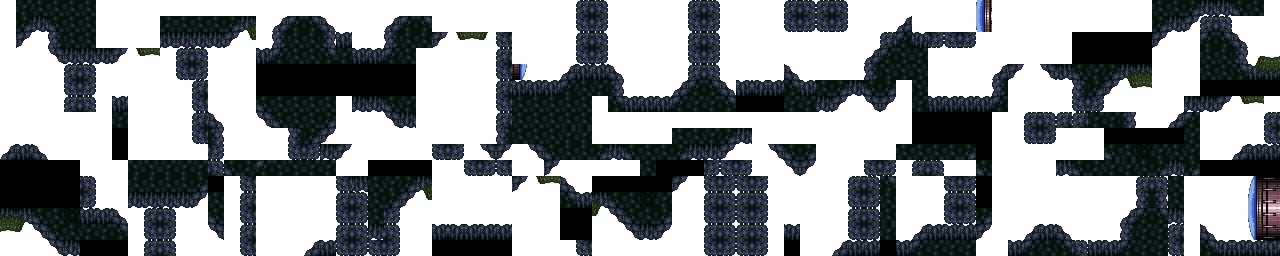

In [167]:
graphics.level_image(l, sce_tiles, cre_tiles)